In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import time

from statistics import mean, stdev
from pytrends.request import TrendReq
from urllib3.exceptions import MaxRetryError

from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import warnings

# our modules
from plotSeries import *
from checkStationarity import *
from GoogleTrendsData import *
from makeDataQuarterly import *
from makeSeriesStationary import *
from predictorsSelection import *
from dataPreProcessing import *
from tsModels import *
from rollingPredictionfuns import *
from fittedAndPredictedValuefuns import *
from bootstrapfuns import *

# 1. Read data (StatCan)

In [2]:
# Reading file
retailsales=pd.read_csv('../../data/retailsalesbyIndustry/retailSalesbyIndustry.csv')

# Renaming columns as required
retailsales.rename(columns = {'REF_DATE':'date', 
                                            'GEO':'LOCATION',
                                            'North American Industry Classification System (NAICS)':'INDUSTRY',
                                            'Adjustments':'ADJUSTMENTS'
                                           },inplace = True)

# Filtering columns as needed and extracting required columns
retailsales_filtered=retailsales[(retailsales['LOCATION'] == 'Canada') & 
                 (retailsales['INDUSTRY'] == 'Retail trade [44-45]')&
                 (retailsales['ADJUSTMENTS'] == 'Seasonally adjusted')&
                 (retailsales['date'] >= '2004-01')]
retailsales_final = retailsales_filtered[['date', 'VALUE']].copy()

#Changing data type of date
retailsales_final['date'] =  pd.to_datetime(retailsales_final['date'])
retailsales_final = retailsales_final.set_index('date')
retailsales_initial = retailsales_final.copy()



# calculate and add growth rate to the dataframe
retailsales_final['GrowthRate']=retailsales_final['VALUE'].pct_change()
retailsales_final = retailsales_final.dropna()

# check sttaionarity of time series
#check_stationarity(retailsales_final[['GrowthRate']])

# 2. Get Google Trends data

#### API call to get predictors data for Retail Trade Sales 

In [3]:
# Reading file for Categories
retailcat=pd.read_csv('../../data/keywords_data/RETAIL_SALES.csv')
retailcatdat = retailcat[['CatNo']].copy()


###################################################################################################
# get dataframe of timeseries for categories (RTS)

keywordsDictQuery = dict() #Dictionary for queries
keywordsDictTopic = dict() #Dictionary for topic


for index, row in retailcatdat.iterrows():
    
    #Calling function
    data, queries, topics = get_trend_RTS(keyword=[''],category=str(row['CatNo']))
    
    
    #Code to append data for different columns in data frame
    
    if index==0:
        FinalData, queries, topics=get_trend_RTS(keyword=[''],category=str(row['CatNo']))
        FinalData.rename(columns = {'':str(row['CatNo'])}, inplace = True)
        FinalData=FinalData.drop(columns=['isPartial'])
    else:
        data, queries, topics=get_trend_RTS(keyword=[''],category=str(row['CatNo']))
        data.rename(columns = {'':str(row['CatNo'])}, inplace = True)
        data=data.drop(columns=['isPartial'])
        data = data[str(row['CatNo'])]
        FinalData = FinalData.join(data)
    
    #Code to store queries in a dictionary
    queries = queries['']['top']
    top5_query = pd.DataFrame(queries['query'].copy().head(5))
    top5_query = top5_query['query'].values.tolist()  
    keywordsDictQuery[str(row['CatNo'])] = top5_query
    
    #Code to store topics in a dictionary
    topics = topics['']['top']
    top5_topic = pd.DataFrame(topics['topic_title'].copy().head(5))
    top5_topic = top5_topic['topic_title'].values.tolist()
    keywordsDictTopic[str(row['CatNo'])] = top5_topic
    
    

# For queries
keywords_query = get_trends_for_dict_RTS(keywordsDictQuery)

#For keywords
#keywords_topics = get_trends_for_dict_RTS(keywordsDictTopic)

In [6]:
# write data to csv
FinalData.to_csv('../../data/storeddata/FinalRetailData.csv')
keywords_query.to_csv('../../data/storeddata/keywords_query_nonstationary.csv')
#keywords_topics.to_csv('../../data/storeddata/keywords_topics_nonstationary.csv')

In [3]:
# Read data from csv
corrcat = pd.read_csv('../../data/storeddata/FinalRetailData.csv')
corrcat = corrcat.set_index('date')

corrquery = pd.read_csv('../../data/storeddata/keywords_query_nonstationary.csv')
corrquery = corrquery.set_index('date')

# corrtopics = pd.read_csv('../../data/storeddata/keywords_topics_nonstationary.csv')
# corrtopics = corrtopics.set_index('date')

# 3. Make data stationary

In [4]:
# RTS
warnings.filterwarnings("ignore")

# getting lag values and storing response and predictors for Random Forest
corrcat.index = pd.to_datetime(corrcat.index)
rf_predictors, rf_response_var = get_lag1_data(corrcat, corrquery, retailsales_final, response_var='GrowthRate')


# 4. Model fit

### Retail Trade Sales

In [5]:
# Apply Random Forest

#Splitting data in training and testing
train_rf, test_rf, extra_rf = ts_train_test_split(rf_response_var, rf_predictors, test_size=0.1)

#Fitting RF model
rfmodel = randomForest_modelfit(train_rf, response_var='GrowthRate', n_trees=100)
x_rf, y_rf = train_rf.loc[:, ~train_rf.columns.isin(['GrowthRate'])], train_rf[['GrowthRate']]

# fitted growth rate
fitted_growthRate_rf = rfmodel.predict(x_rf)
fitted_growthRate_rf = pd.DataFrame(fitted_growthRate_rf, columns={'Fitted GrowthRate'})
fitted_growthRate_rf.index = train_rf.index

#Random Forest Predictions
rf_pred_retailgrowth = rolling_prediction_RF(train_rf, test_rf, extra_rf,dependent_var='GrowthRate',
                                              n_trees=100)

#rf_pred_retailgrowth

# Fitted and predicted retail sales value
pred_error, fig, data = fitted_and_predicted_retail(rfmodel, 
                                                    rf_pred_retailgrowth, 
                                                    retailsales_initial, train_rf, test_rf, extra_rf)
pred_error

Prediction error: 2671145.161448739


2671145.161448739

In [6]:
# Bootstrap for Retail

# create bootstrap samples
bs_samples = get_bootstrap_samples(train_rf, n_sample=2, rs=None)  # RandomState(1234)

# get predicted growth rate uisng bootstrap samples
predicted_rsales_df = pd.DataFrame(columns=list(range(0, len(bs_samples))))
for i, df in enumerate(bs_samples):
    predicted_rsales_temp = rolling_prediction_RF(df, test_rf, extra_rf, dependent_var='GrowthRate')
    predicted_rsales_df.iloc[:, i] = predicted_rsales_temp[0]

# get predicted RTS value for bootstrap samples
predicted_retail_df_bs = pd.DataFrame(columns=list(range(0, len(bs_samples))))
for i in range(0, len(bs_samples)):
    predicted_growth_rate_temp = predicted_rsales_df[[i]].rename(columns={i: 0})
    _, _, retail_data = fitted_and_predicted_retail(rfmodel, predicted_growth_rate_temp, retailsales_initial, train_rf, test_rf, extra_rf)
    predicted_retail_df_bs.iloc[:, i] = retail_data['Predicted Retail'].dropna()



Prediction error: 2661231.5218821
Prediction error: 2942666.206874159


In [7]:
#Plots
fig1, data = growth_rate_plot_and_data_RTS(predicted_growth_df=predicted_rsales_df,
                              lower_q = 0.025,
                              upper_q = 0.975,
                              modelfit= rfmodel, 
                              retailsales_final = retailsales_final, 
                              train = train_rf,
                              rf_pred_retailgrowth = rf_pred_retailgrowth,
                              fitted_growthRate_rf = fitted_growthRate_rf)    
    
fig2, pred_retail_data = retail_plot_and_data_bs(rfmodel, 
                                                 rf_pred_retailgrowth, 
                                                 retailsales_initial, 
                                                 train_rf, 
                                                 test_rf, 
                                                 extra_rf, 
                                                 predicted_retail_df_bs,
                                                lower_q = 0.025, upper_q = 0.975)

Prediction error: 2671145.161448739


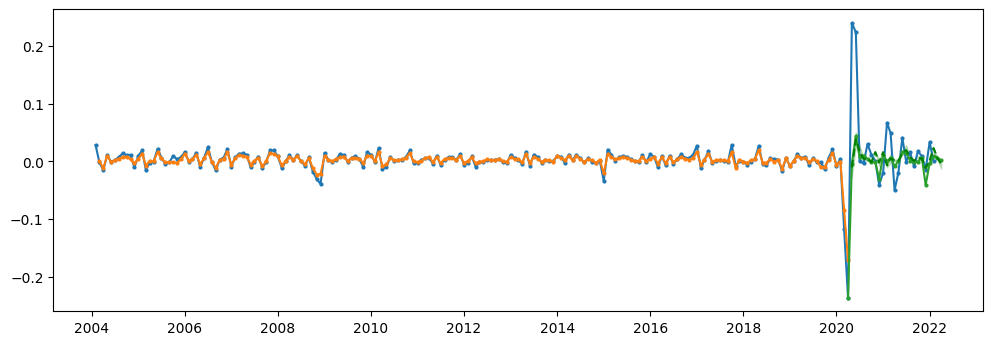

In [8]:
fig1

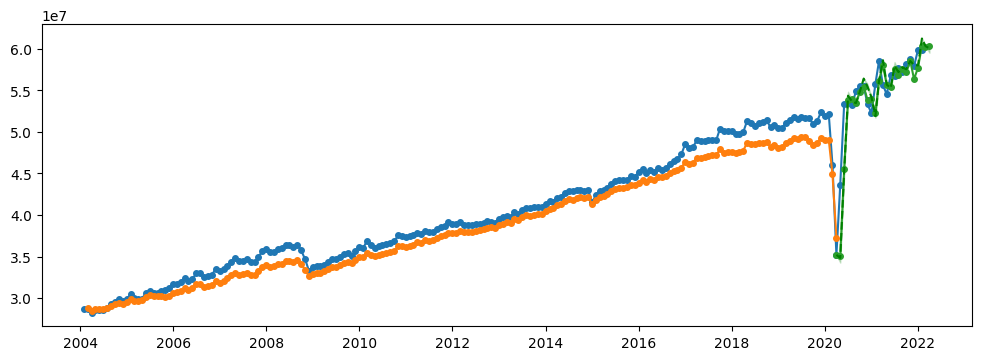

In [9]:
fig2